![Capture d'écran](workflow.PNG)

# 1 - Téléchargement d'un fichier .MP3

Cette étape n'est pas décrite car les audios peuvent provenir de plusieurs sources, il s'agit d'une collection privée pour l'exemple.

# 2 - Transcription de l'audio

In [ ]:
import whisper

def transcribe_audio(audio_path, output_txt="transcription.txt"):
    model = whisper.load_model("small")
    result = model.transcribe(audio_path)

    with open(output_txt, "w", encoding="utf-8") as f:
        f.write(result["text"])

    print(f"Transcription sauvegardée dans {output_txt}")

audio_file = "downloads/Trump aide à l’Ukraine… contre ses ressources naturelles.mp3"
transcribe_audio(audio_file)


Transcription sauvegardée dans "transcription.txt".

Le président américain Donald Trump a déclaré cette semaine ...

# 3 - Découpage de "transcription.txt" pour l'analyse

In [ ]:
import nltk
import pandas as pd
import os

nltk.download("punkt")
nltk.download("punkt_tab")

def chunk_text(text): 
    sentences = nltk.tokenize.sent_tokenize(text, language="french") 
    return sentences

def process_transcription(file_path, output_csv="dataset_chunks.csv"):
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    chunks = chunk_text(text)

    df = pd.DataFrame({"chunk_id": range(len(chunks)), "text": chunks})
    
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"Fichier CSV généré : {output_csv}")

process_transcription("transcription.txt")


In [2]:
import pandas as pd
df = pd.read_csv(r'data\dataset_chunks.csv')
df.head() 

,chunk_id,text
0,0,Le président américain Donald Trump a déclaré...
1,1,Des déclarations qui ont fait beaucoup parler ...
2,2,Alors quel est-elle et que réclame précisément...
3,3,"Salut ces blanches, Hugo est à nouveau absent ..."
4,4,On est parti pour un nouveau résumé de l'actua...


## 4 - Annotation du dataset
Le dataset est annoté en fonction des émotions susceptibles d'être ressenties par l'auditeur, le panel des émotions retenu pour ce démonstrateur est celui décrit par Grahn, D. H., & Pamment, D. J. (n.d.). Exploitation of psychological processes in information influence operations.


In [10]:
df = pd.read_csv(r'data\annotated_dataset.csv')
print(df.head())

   chunk_id                                               text  Fear  Anger  \
0         0   Le président américain Donald Trump a déclaré...     0      0   
1         1  Des déclarations qui ont fait beaucoup parler ...     0      0   
2         2  Alors quel est-elle et que réclame précisément...     0      0   
3         3  Salut ces blanches, Hugo est à nouveau absent ...     0      0   
4         4  On est parti pour un nouveau résumé de l'actua...     0      0   

   Hope  Confusion  Outrage  Uncertainty  Empathy  Neutral  
0     0          0        0            1        0        0  
1     0          0        0            0        0        1  
2     0          0        0            0        0        1  
3     0          0        0            0        0        1  
4     0          0        0            0        0        1  


Statistiques descriptives :
             Fear       Anger        Hope   Confusion     Outrage  \
count  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.079208    0.039604    0.069307    0.089109    0.059406   
std      0.271410    0.196000    0.255242    0.286322    0.237562   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       Uncertainty     Empathy     Neutral  
count   101.000000  101.000000  101.000000  
mean      0.138614    0.059406    0.673267  
std       0.347267    0.237562    0.471358  
min       0.000000    0.000000    0.000000  
25%       0.000000    0.000000    0.000000  
50%       0.000000    0.000000    1.000000  
75%       0.000000    0.000000    1

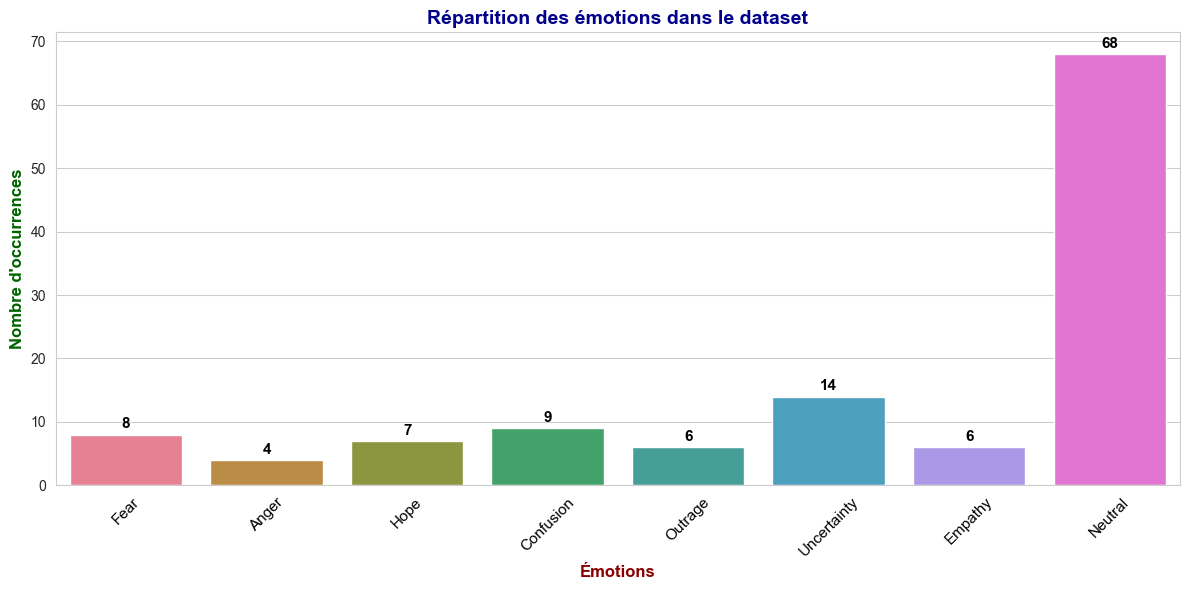


Pourcentage de chaque émotion :
Fear: 7.92%
Anger: 3.96%
Hope: 6.93%
Confusion: 8.91%
Outrage: 5.94%
Uncertainty: 13.86%
Empathy: 5.94%
Neutral: 67.33%


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

file_path = "data/annotated_dataset.csv"
df = pd.read_csv(file_path)

print("Statistiques descriptives :")
print(df.drop("chunk_id", axis=1).describe())

emotion_columns = ["Fear", "Anger", "Hope", "Confusion", "Outrage", "Uncertainty", "Empathy", "Neutral"]
emotions_sum = df[emotion_columns].sum()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

colors = sns.color_palette("husl", len(emotion_columns))

ax = sns.barplot(x=emotions_sum.index, y=emotions_sum.values, hue=emotions_sum.index, palette=colors, legend=False)

plt.title("Répartition des émotions dans le dataset", fontsize=14, fontweight="bold", color="darkblue")
plt.xlabel("Émotions", fontsize=12, fontweight="bold", color="darkred")
plt.ylabel("Nombre d'occurrences", fontsize=12, fontweight="bold", color="darkgreen")
plt.xticks(rotation=45, fontsize=11, color="black")

for i, v in enumerate(emotions_sum.values):
    ax.text(i, v + 0.5, str(int(v)), ha="center", va="bottom", fontsize=11, fontweight="bold", color="black")

plt.tight_layout()
plt.show()

print("\nPourcentage de chaque émotion :")
percentages = (emotions_sum / len(df) * 100).round(2)
for emotion, percentage in percentages.items():
    print(f"{emotion}: {percentage}%")

# 5 - zero-shot learning 

A défaut d'un modèle spécifiquement entraîné pour la reconnaissance des émotions probables chez l'auditeur parmi les labels *["Fear", "Anger", "Hope", "Confusion", "Outrage", "Uncertainty", "Empathy", "Neutral"]* nous choississons de classifier un second texte **France24.txt** à l'aide de `gpt-4o`

In [ ]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

MODEL = "gpt-4o"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

label_columns = ["Fear", "Anger", "Hope", "Confusion", "Outrage", "Uncertainty", "Empathy", "Neutral"]

def classify_text(text):
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "Classify the text based on emotions likely felt by the listener: " + ", ".join(label_columns) + "."},
            {"role": "user", "content": f"Classify the following text into one or more of these emotions. If none apply, return 'Neutral': {text}"}
        ]
    )
    
    emotions = {label: 0 for label in label_columns}
    detected_emotions = completion.choices[0].message.content.split(", ")
    
    if "Neutral" in detected_emotions and len(detected_emotions) == 1:
        emotions["Neutral"] = 1
    else:
        for emotion in detected_emotions:
            if emotion in emotions:
                emotions[emotion] = 1

    return emotions

def annotate_dataset(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    df_annotated = df["text"].apply(classify_text).apply(pd.Series)
    df_result = pd.concat([df, df_annotated], axis=1)
    df_result.to_csv(output_csv, index=False)
    print(f"Annotation terminée : {output_csv}")

input_file = "data/France24_chunks.csv"
output_file = "data/France24_annotated.csv"

annotate_dataset(input_file, output_file)


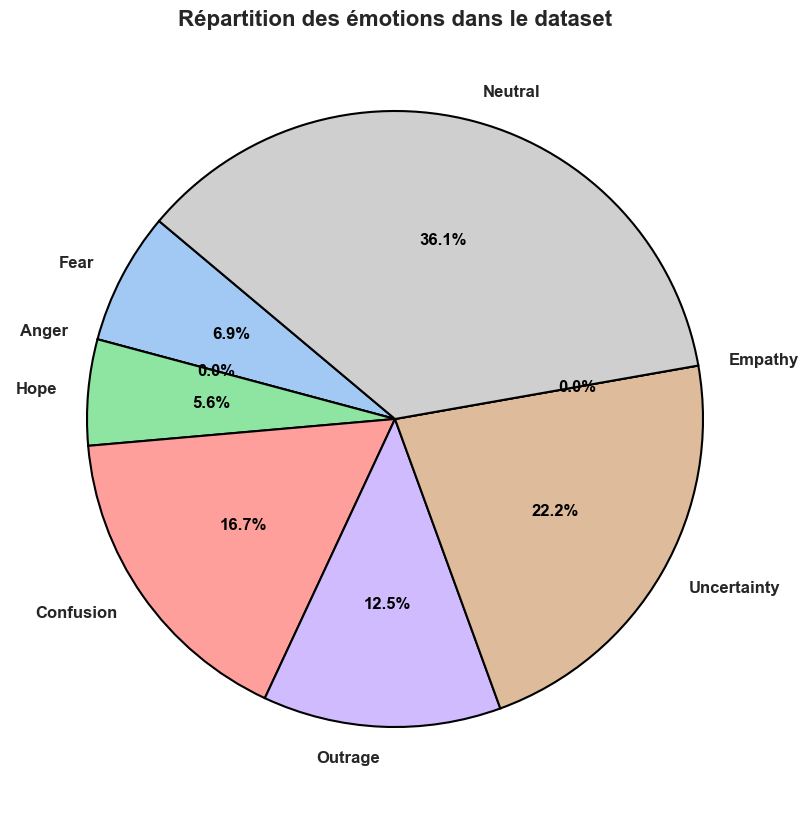

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier CSV
file_path = "data/France24_annotated.csv"

df = pd.read_csv(file_path)


emotion_columns = ["Fear", "Anger", "Hope", "Confusion", "Outrage", "Uncertainty", "Empathy", "Neutral"]
emotion_counts = df[emotion_columns].sum()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
colors = sns.color_palette("pastel")
wedges, texts, autotexts = plt.pie(
    emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', 
    startangle=140, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title("Répartition des émotions dans le dataset", fontsize=16, fontweight='bold')
plt.show()


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

file_path = "data/France24_annotated.csv"
df = pd.read_csv(file_path)

emotion_columns = ["Fear", "Anger", "Hope", "Confusion", "Outrage", "Uncertainty", "Empathy"]

triggered_sentences = df[df[emotion_columns].sum(axis=1) > 0][["text"] + emotion_columns]

def highlight_emotions(val):
    color_map = {
        "Fear": "background-color: #FF9999", "Anger": "background-color: #FF6347", "Hope": "background-color: #90EE90",
        "Confusion": "background-color: #FFD700", "Outrage": "background-color: #FF4500", "Uncertainty": "background-color: #87CEFA",
        "Empathy": "background-color: #DDA0DD"
    }
    return color_map.get(val, "")

styled_df = triggered_sentences.copy()
for emotion in emotion_columns:
    styled_df[emotion] = styled_df[emotion].apply(lambda x: emotion if x == 1 else "")

styled_df = styled_df.style.map(highlight_emotions).set_properties(**{'text-align': 'left'})
display(styled_df)


,text,Fear,Anger,Hope,Confusion,Outrage,Uncertainty,Empathy
0,"Et pour essayer de comprendre un peu plus ce qu'il s'est dit à Munich avec nous, Richard Verlie.",,,,Confusion,,,
3,"Richard Verlie, le moins que l'on puisse dire, c'est que les Européens sont toujours sous le choc interloqué par cet attaque du vice-président américain sur la démocratie en Europe.",,,,Confusion,,,
4,"Oui, ils ont compris une chose les Européens, c'est qu'au fond, une forme de guerre culturelle est déclarée par l'administration américaine.",Fear,,,,Outrage,,
6,"L'Europe doit respecter ce que les États-Unis considèrent comme la démocratie, c'est-à-dire doit donner davantage la parole aux formations d'extrême droite.",,,,Confusion,Outrage,,
7,"L'Europe doit également déréguler, donc abandonner sa passion des normes.",,,,,Outrage,,
8,"Et enfin, dernier élément, c'est très important, l'Europe doit retrouver la liberté d'expression, puisque selon Elon Musk, vous le savez, il l'a souvent dit, selon Donald Trump et selon J. de Vence, aujourd'hui, cette liberté d'expression est baïonnée sur le continent.",,,,,Outrage,Uncertainty,
9,"Donc vous imaginez le choc qui a représenté une telle affirmation dans un discours assez agressif, lors d'une conférence sur la sécurité qui, normalement, à Munich chaque année, célèbre l'alliance entre les États-Unis et les Européens.",,,,Confusion,Outrage,,
10,Que vous inspirez les premières réactions enregistrées?,,,,Confusion,,,
12,Est-ce que c'est une posture?,,,,Confusion,,,
13,"De la mesure où on s'imagine que chez les Hongois de Victor-Orban, par exemple, le message n'a pas été reçu de la même manière.",,,,,,Uncertainty,
